In [1]:
from src.api import API
from src.dataloader import DataLoader
from src.prompter import prompter_factory
from src.scorer import scorer_factory

In [2]:
TOGETHER_API_KEY = "92a6ac4a8feb39c91b4a3f77219e9c452d927f5f4d543d5969cc11c210795719"
BASE_URL = "https://api.together.xyz"
ALLOWED_SYMPTOMS = ['anxiety', 'concentration problems', 'constipation', 'cough',
                    'diarrhea', 'fatigue', 'fever', 'headache', 'nausea', 
                    'numbness and tingling', 'pain', 'poor appetite', 'rash', 
                    'shortness of breath', 'trouble drinking fluids', 'vomiting', 'other']

Using the API class provides a modular approach to client definition.

In [3]:
api = API(api_key=TOGETHER_API_KEY, base_url=BASE_URL)
client = api.get_openai()

The DataLoader class loads the csv files. It verifies their existence and provides testing tools.

DataLoader allows for dataframe creation, with uniformization of the labels and column formatting.

In [4]:
dataloader = DataLoader(path="data/")
print(dataloader.list_csv_files())

['data/batch_1_gs.csv', 'data/batch_2_gs.csv', 'data/batch_3_gs.csv', 'data/batch_4_gs.csv', 'data/batch_5_gs.csv', 'data/batch_6_gs.csv', 'data/batch_7_gs.csv', 'data/batch_8_gs.csv', 'data/batch_9_gs.csv', 'data/batch_10_gs.csv']


In [5]:
df = dataloader.get_standardized_dataframe(context_col="Text Data",
                                           target_binary_col="symptom_status_gs",
                                           target_multilabel_col="symptom_detail_gs",
                                           keep_other_cols=True)
dataloader.check_symptoms_validity(allowed_symptoms=ALLOWED_SYMPTOMS,
                                   symptoms_col="symptom_detail_gs")

Symptoms in dataframe are valid.


In [8]:
Mixtral8x7B = prompter_factory(prompter_type="binary",
                               client=client,
                               model="meta-llama/Llama-2-70b-chat-hf")

In [9]:
prompt = "Are any medical symptoms mentioned in the transcript"
context = "i have a headache every time i see a cat and i hear voices that are not there"
print(Mixtral8x7B.generate_single(prompt=prompt, context=context))

{'status': True, 'output': "  Yes, there are several medical symptoms mentioned in the transcript:\n\n1. Headache: The person mentions having a headache every time they see a cat.\n2. Hallucinations: The person hears voices that are not there. This could be a symptom of a mental health condition such as schizophrenia or a neurological disorder.\n\nIt's important to note that these are just a couple of examples, and it's not appropriate to diagnose or speculate on someone's medical condition based on a short transcript. If you are experiencing symptoms, it's important to consult with a qualified medical professional for an accurate diagnosis and appropriate treatment."}


In [8]:
# This operation is parallelized - the progress bar is not linear.
results = Mixtral8x7B.generate(df=df, prompt=prompt, export_to_path="results/mixtral8x7b_binary/prompt1.csv")

binary task using: mistralai/Mixtral-8x7B-Instruct-v0.1: 100%|██████████| 550/550 [00:12<00:00, 43.78it/s]


In [9]:
scorer = scorer_factory(scorer_type="binary", data=df, results=results)
scorer.display_bootstrap_results(sample_size=len(df),
                                 output_type="text",
                                 n_samples=1000)

Bootstrapping: 100%|██████████| 1000/1000 [00:07<00:00, 126.95it/s]

accuracy: 0.8141 (0.78-0.8473 95% CI)
precision: 0.8563 (0.8219-0.8889 95% CI)
recall: 0.8783 (0.8441-0.9108 95% CI)
f1: 0.867 (0.8407-0.8918 95% CI)


Bootstrapping: 100%|██████████| 1000/1000 [00:08<00:00, 117.83it/s]


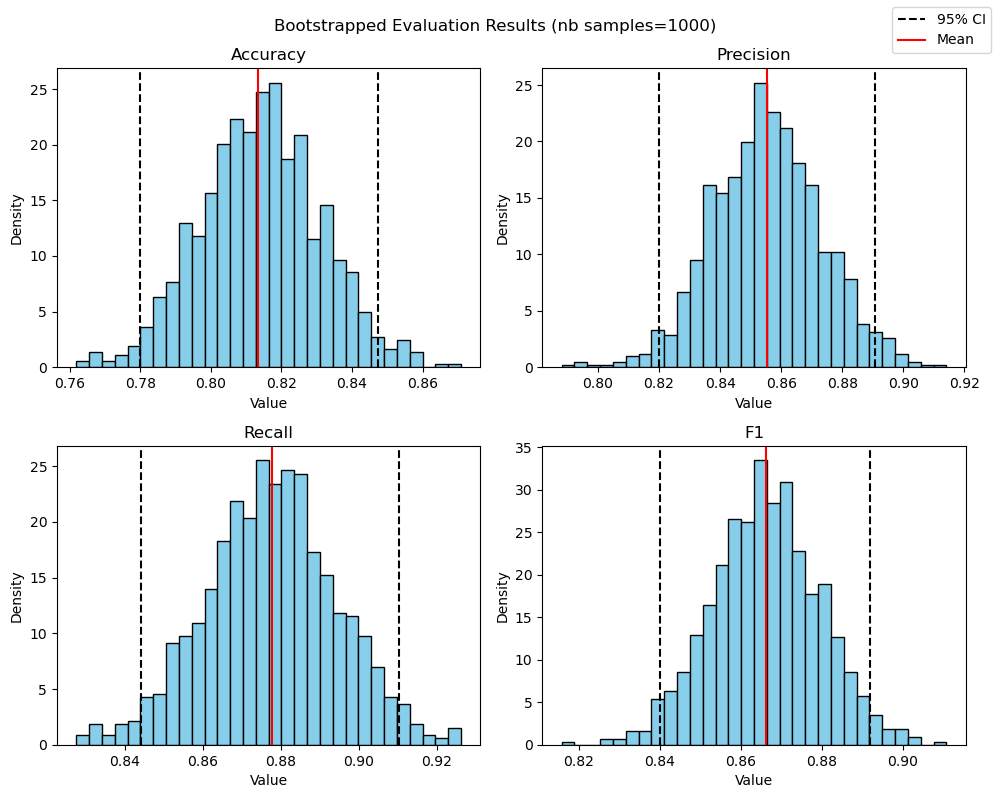

In [10]:
scorer.display_bootstrap_results(sample_size=len(df),
                                 output_type="plot",
                                 n_samples=1000)